In [1]:
# =========================
# Regresión Logística en Keras — Clasificación binaria
# =========================
# Instalación de dependencias (solo una vez)
!pip install -q 'protobuf<6,>=3.20'
!pip install -q tensorflow==2.20.0 scikit-learn matplotlib joblib pandas numpy


# ---- Importaciones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

# TensorFlow / Keras
from tensorflow import keras
from tensorflow.keras import layers

# Guardado de modelos
import joblib

# ---- Confirmación de versiones (opcional pero útil)
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)
print("Dispositivos:", tf.config.list_physical_devices())



2025-10-16 23:11:48.649147: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 23:11:48.649480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 23:11:48.688001: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.20.0
Keras: 3.11.3
Dispositivos: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-10-16 23:11:49.623393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 23:11:49.623889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 23:11:49.750183: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Métricas TEST — Regresión Logística (thr=0.5):
Accuracy : 0.725
Precision: 0.719
Recall   : 0.820
F1       : 0.766
AUC-ROC  : 0.754
Matriz de confusión:
 [[25 16]
 [ 9 41]]
              precision    recall  f1-score   support

           0      0.735     0.610     0.667        41
           1      0.719     0.820     0.766        50

    accuracy                          0.725        91
   macro avg      0.727     0.715     0.717        91
weighted avg      0.727     0.725     0.721        91



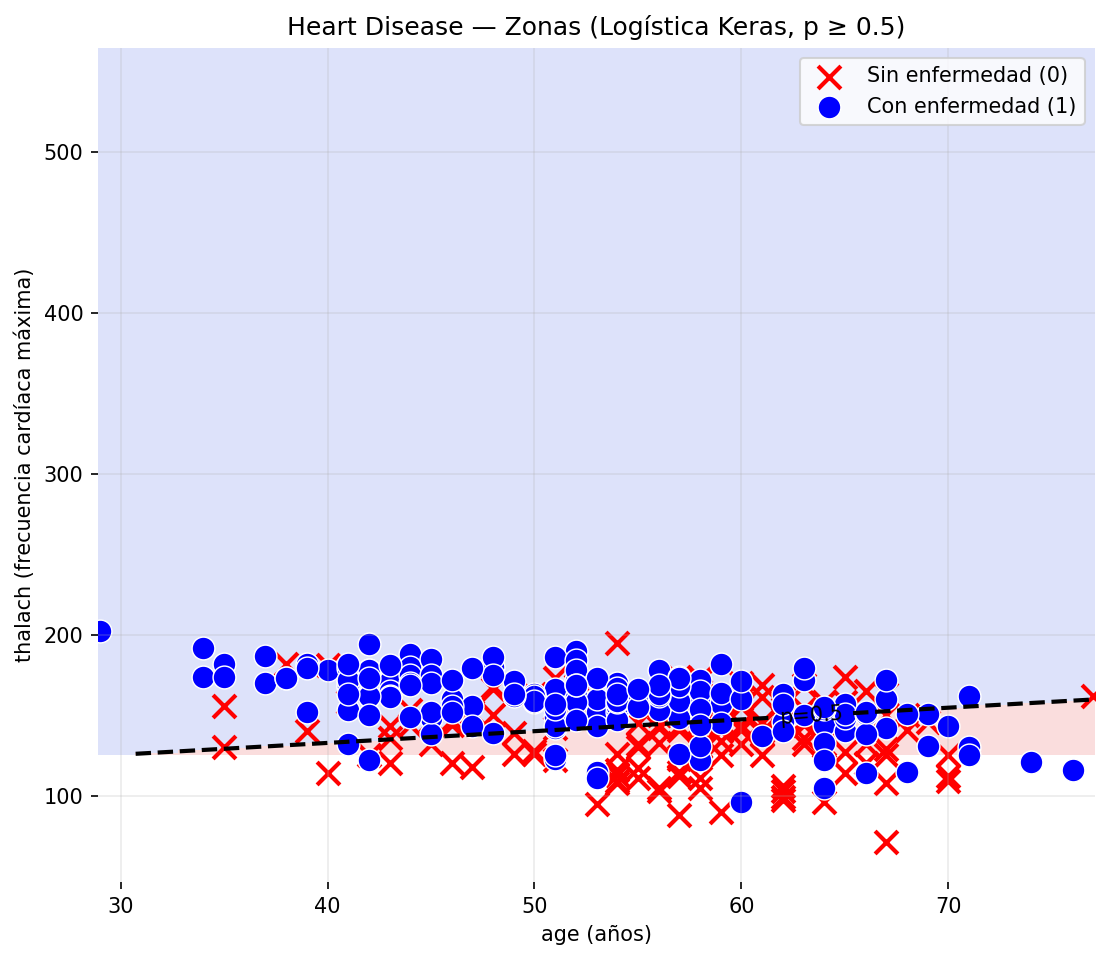

Guardado: logreg_sigmoid.keras, scaler_minmax.joblib


In [5]:
# ---- 0) Datos
#df = pd.read_csv("heart.csv")
# Usaremos 2 variables para poder graficar la frontera 2D:
#assert set(["age","chol","target"]).issubset(df.columns)
#X = df[["age","chol"]].values.astype(float)
#y = df["target"].astype(int).values  # 0/1
# ---- 0) Datos
df = pd.read_csv("heart.csv")
# Usaremos 2 variables para poder graficar la frontera 2D:
assert set(["age","thalach","target"]).issubset(df.columns)
X = df[["age","thalach"]].values.astype(float)
y = df["target"].astype(int).values  # 0/1


# ---- 1) Split + Escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ---- 2) Modelo Logístico (1 neurona, sigmoide)
logreg = keras.Sequential([
    layers.Dense(1, activation="sigmoid", input_shape=(2,))
])
logreg.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
               loss="binary_crossentropy",
               metrics=["accuracy"])

cb = keras.callbacks.EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)
logreg.fit(X_train_sc, y_train, epochs=2000, batch_size=len(X_train_sc),
           callbacks=[cb], verbose=0)  # batch GD

# ---- 3) Evaluación (thr=0.5)
probs_test = logreg.predict(X_test_sc, verbose=0).ravel()
y_pred_test = (probs_test >= 0.5).astype(int)

print("Métricas TEST — Regresión Logística (thr=0.5):")
print(f"Accuracy : {accuracy_score(y_test, y_pred_test):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_test, zero_division=0):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_test, zero_division=0):.3f}")
print(f"F1       : {f1_score(y_test, y_pred_test, zero_division=0):.3f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, probs_test):.3f}")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits=3))

# ---- 4) Zonas (p>=0.5) + frontera p=0.5
res = 300
x_min, x_max = df["age"].min(),  df["age"].max()
y_min, y_max = df["chol"].min(), df["chol"].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, res),
                     np.linspace(y_min, y_max, res))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_sc = scaler.transform(grid)
probs = logreg.predict(grid_sc, verbose=0).ravel().reshape(xx.shape)
zz = (probs >= 0.5).astype(int)

cmap_bg = ListedColormap(["#f8c7c7", "#c7cff8"])
plt.figure(figsize=(7.5, 6.5), dpi=150)
plt.title("Heart Disease — Zonas (Logística Keras, p ≥ 0.5)")
plt.pcolormesh(xx, yy, zz, shading="auto", cmap=cmap_bg, alpha=0.6)
cs = plt.contour(xx, yy, probs, levels=[0.5], linestyles="--", linewidths=2, colors="k")
try: plt.clabel(cs, fmt={0.5: "p=0.5"}, inline=True)
except: pass
plt.scatter(X[y==0,0], X[y==0,1], marker="x", s=120, color="red",  linewidths=2.0, label="Sin enfermedad (0)")
plt.scatter(X[y==1,0], X[y==1,1], marker="o", s=120, color="blue", edgecolor="white", linewidths=0.7, label="Con enfermedad (1)")
plt.xlabel("age (años)")
plt.ylabel("thalach (frecuencia cardíaca máxima)")
plt.legend(loc="upper right"); plt.grid(alpha=0.25); plt.box(False); plt.tight_layout(); plt.show()

# ---- 5) Guardar
logreg.save("logreg_sigmoid.keras")
joblib.dump(scaler, "scaler_minmax.joblib")
print("Guardado: logreg_sigmoid.keras, scaler_minmax.joblib")

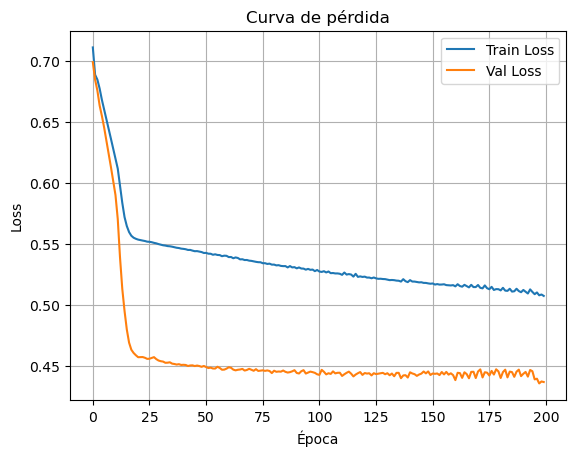

In [9]:
# ============================
# MLP binario (heart.csv) — age, thalach, oldpeak
# Entrenamiento con validation_split=0.2
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import tensorflow as tf, random

# (Opcional) Semillas para reproducibilidad
np.random.seed(42); random.seed(42); tf.random.set_seed(42)

# 1) Cargar y preparar datos
df = pd.read_csv("heart.csv")
X = df[["age", "thalach", "oldpeak"]].values.astype(float)
y = df["target"].astype(int).values  # 0/1

# 2) Escalar
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3) Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 4) Arquitectura (3 entradas)
model_clf = Sequential([
    Input(shape=(3,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 5) Compilar
model_clf.compile(optimizer=Adam(learning_rate=0.005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# 6) Entrenar con validation_split=0.2 (Keras toma el 20% FINAL de X_train)
hist = model_clf.fit(
    X_train, y_train,
    epochs=200, verbose=0,
    validation_split=0.2
)

# (Opcional) Curva de pérdida
plt.plot(hist.history["loss"], label="Train Loss")
plt.plot(hist.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Curva de pérdida"); plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(); plt.show()


In [10]:
# ============================
# Selección de umbral en validación y evaluación en TEST
# ============================
import numpy as np
from sklearn.metrics import f1_score

# Reconstruir el conjunto de VALIDACIÓN usado por validation_split=0.2
n_val = int(0.2 * X_train.shape[0])
X_val, y_val   = X_train[-n_val:], y_train[-n_val:]     # último 20%
X_trn, y_trn   = X_train[:-n_val], y_train[:-n_val]     # primer 80% (no lo usamos aquí)

# Predicciones de probabilidad en VALIDACIÓN
val_prob = model_clf.predict(X_val, verbose=0).ravel()

# Barrer umbrales y elegir el que maximiza F1
ths = np.linspace(0.25, 0.75, 101)
best_th, best_f1 = 0.5, -1.0
for th in ths:
    f1 = f1_score(y_val, (val_prob >= th).astype(int))
    if f1 > best_f1:
        best_f1, best_th = f1, th

print(f"Umbral óptimo en validación: {best_th:.2f}  |  F1(val) = {best_f1:.3f}")

# Evaluación en TEST con ese umbral
y_prob_test = model_clf.predict(X_test, verbose=0).ravel()
y_pred_test = (y_prob_test >= best_th).astype(int)

print("Accuracy (TEST):", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits=3))


Umbral óptimo en validación: 0.42  |  F1(val) = 0.902
Accuracy (TEST): 0.7252747252747253
              precision    recall  f1-score   support

           0      0.750     0.585     0.658        41
           1      0.712     0.840     0.771        50

    accuracy                          0.725        91
   macro avg      0.731     0.713     0.714        91
weighted avg      0.729     0.725     0.720        91



ValueError: X has 2 features, but MinMaxScaler is expecting 3 features as input.

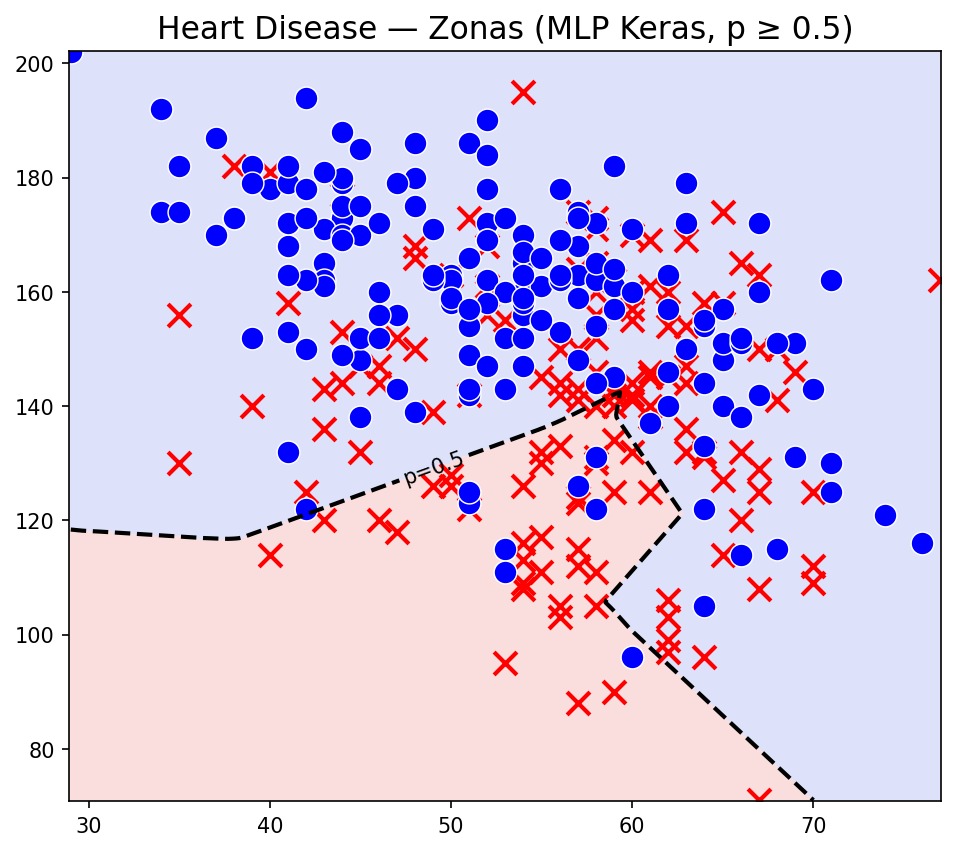

In [14]:
# =========================================
# Zonas de aprobación (MLP — Keras) con 2 variables (age, thalach)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1) Malla en unidades originales (usamos 2 primeras para graficar, pero completamos con "oldpeak")
res = 300
x_min, x_max = df["age"].min(),  df["age"].max()
y_min, y_max = df["thalach"].min(), df["thalach"].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, res),
                     np.linspace(y_min, y_max, res))

# **Aquí creamos una malla con 3 columnas:**
# Agregamos `oldpeak` constante (por ejemplo, 0)
oldpeak = np.zeros(xx.ravel().shape)  # crea un array de ceros con la misma forma que xx y yy
grid_orig = np.c_[xx.ravel(), yy.ravel(), oldpeak]  # concatenamos `oldpeak` a la malla

# 2) Escalar la malla con el MISMO scaler usado para el entrenamiento
grid_sc = scaler.transform(grid_orig)

# 3) Probabilidades y umbral 0.5
probs = model_clf.predict(grid_sc, verbose=0).ravel().reshape(xx.shape)
zz = (probs >= 0.5).astype(int)

# 4) Fondo + puntos + frontera p=0.5
cmap_bg = ListedColormap(["#f8c7c7", "#c7cff8"])  # 0 rojo claro, 1 azul claro
plt.figure(figsize=(7.5, 6.5), dpi=150)
plt.title("Heart Disease — Zonas (MLP Keras, p ≥ 0.5)", fontsize=15)

# Fondo
plt.pcolormesh(xx, yy, zz, shading="auto", cmap=cmap_bg, alpha=0.6)

# Frontera p=0.5
cs = plt.contour(xx, yy, probs, levels=[0.5], linestyles="--", linewidths=2, colors="k")
try:
    plt.clabel(cs, fmt={0.5: "p=0.5"}, inline=True)
except:
    pass

# Puntos del dataset (solo las 2 primeras variables para el gráfico)
Xo = df[["age", "thalach"]].values
yo = df["target"].astype(int).values
plt.scatter(Xo[yo==0,0], Xo[yo==0,1], marker="x", s=120, color="red", linewidths=2, label="Sin enfermedad (0)")
plt.scatter(Xo[yo==1,0], Xo[yo==1,1], marker="o", s=120, color="blue", edgecolor="white", linewidths=0.7, label="Con enfermedad (1)")

# (Opcional) Nuevo caso ⭐
X_new = np.array([[45, 150], [150, 350]], dtype=float)  # ejemplo: nuevos casos para predecir
p_new = model_clf.predict(scaler.transform(X_new), verbose=0).ravel()
plt.scatter(X_new[:,0], X_new[:,1], s=180, marker="*", edgecolor="k", color="gold",
            label=f"Nuevo (p={p_new[0]:.2f}, {p_new[1]:.2f})")

plt.xlabel("Edad (años)"); plt.ylabel("Ritmo cardíaco máximo (thalach)")
plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
plt.grid(alpha=0.25); plt.legend(loc="upper right")
plt.box(False); plt.tight_layout(); plt.show()


## Pero para que salga acá usaremos solo 2 columnas "age" y "thalach"

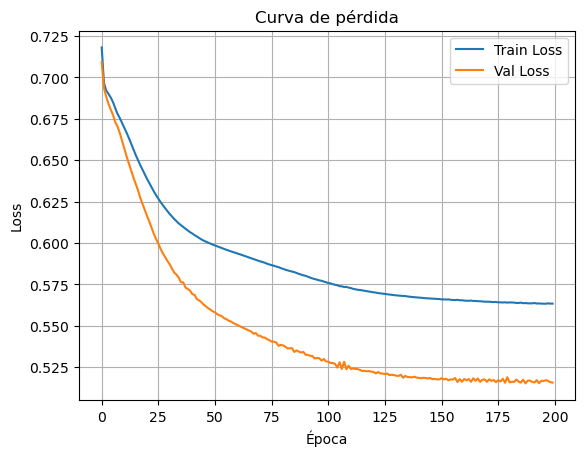

In [15]:
# ============================
# MLP binario (heart.csv) — solo con age, thalach
# Entrenamiento con validation_split=0.2
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import tensorflow as tf, random

# (Opcional) Semillas para reproducibilidad
np.random.seed(42); random.seed(42); tf.random.set_seed(42)

# 1) Cargar y preparar datos
df = pd.read_csv("heart.csv")
X = df[["age", "thalach"]].values.astype(float)  # Solo age y thalach
y = df["target"].astype(int).values  # 0/1

# 2) Escalar
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3) Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 4) Arquitectura (2 entradas: age, thalach)
model_clf = Sequential([
    Input(shape=(2,)),  # Cambié a 2 para usar solo age y thalach
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 5) Compilar
model_clf.compile(optimizer=Adam(learning_rate=0.005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# 6) Entrenar con validation_split=0.2 (Keras toma el 20% FINAL de X_train)
hist = model_clf.fit(
    X_train, y_train,
    epochs=200, verbose=0,
    validation_split=0.2
)

# (Opcional) Curva de pérdida
plt.plot(hist.history["loss"], label="Train Loss")
plt.plot(hist.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Curva de pérdida"); plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(); plt.show()


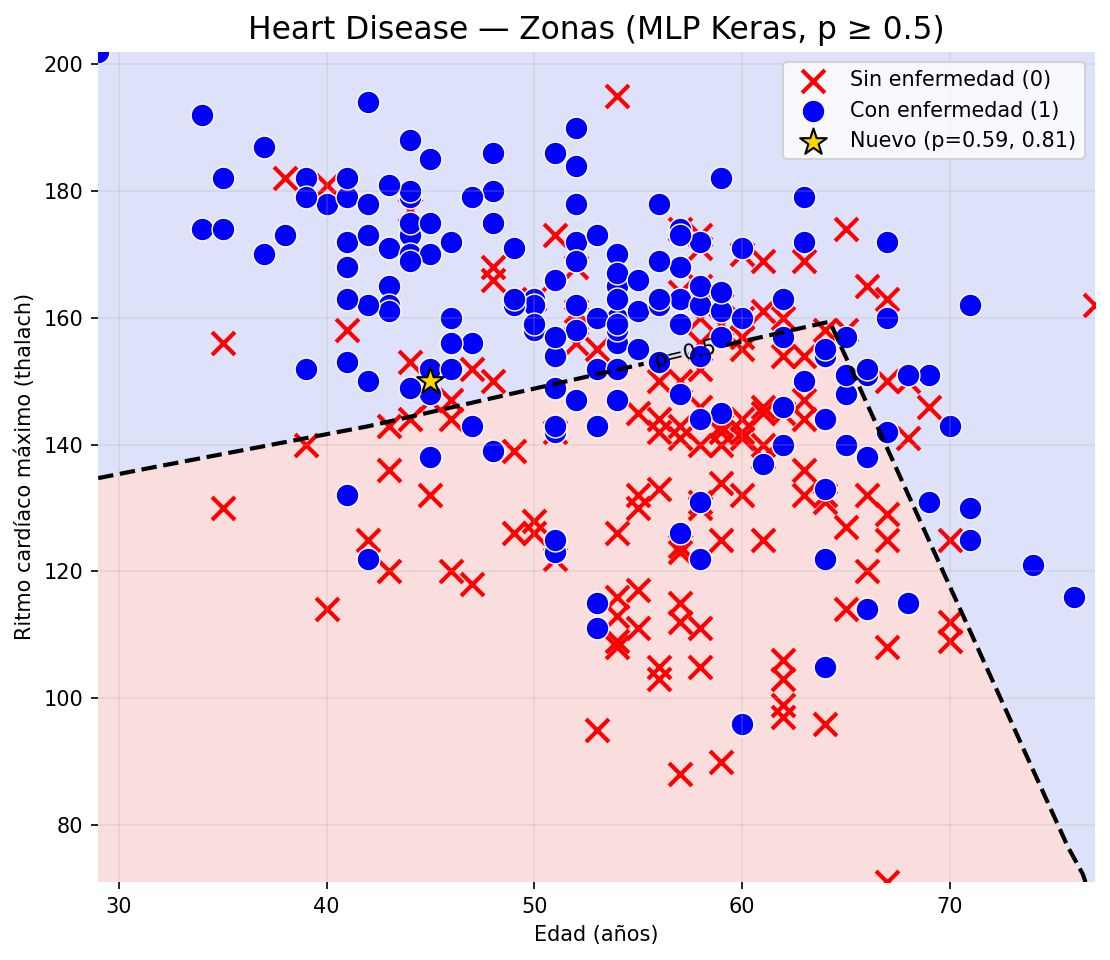

In [16]:
# =========================================
# Zonas de aprobación (MLP — Keras) con 2 variables (age, thalach)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1) Malla en unidades originales (solo age y thalach)
res = 300
x_min, x_max = df["age"].min(),  df["age"].max()
y_min, y_max = df["thalach"].min(), df["thalach"].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, res),
                     np.linspace(y_min, y_max, res))
grid_orig = np.c_[xx.ravel(), yy.ravel()]  # Solo dos columnas

# 2) Escalar la malla con el MISMO scaler usado para el entrenamiento
grid_sc = scaler.transform(grid_orig)

# 3) Probabilidades y umbral 0.5
probs = model_clf.predict(grid_sc, verbose=0).ravel().reshape(xx.shape)
zz = (probs >= 0.5).astype(int)

# 4) Fondo + puntos + frontera p=0.5
cmap_bg = ListedColormap(["#f8c7c7", "#c7cff8"])  # 0 rojo claro, 1 azul claro
plt.figure(figsize=(7.5, 6.5), dpi=150)
plt.title("Heart Disease — Zonas (MLP Keras, p ≥ 0.5)", fontsize=15)

# Fondo
plt.pcolormesh(xx, yy, zz, shading="auto", cmap=cmap_bg, alpha=0.6)

# Frontera p=0.5
cs = plt.contour(xx, yy, probs, levels=[0.5], linestyles="--", linewidths=2, colors="k")
try:
    plt.clabel(cs, fmt={0.5: "p=0.5"}, inline=True)
except:
    pass

# Puntos del dataset (solo age y thalach)
Xo = df[["age", "thalach"]].values
yo = df["target"].astype(int).values
plt.scatter(Xo[yo==0,0], Xo[yo==0,1], marker="x", s=120, color="red", linewidths=2, label="Sin enfermedad (0)")
plt.scatter(Xo[yo==1,0], Xo[yo==1,1], marker="o", s=120, color="blue", edgecolor="white", linewidths=0.7, label="Con enfermedad (1)")

# (Opcional) Nuevo caso ⭐
X_new = np.array([[45, 150], [150, 350]], dtype=float)  # ejemplo: nuevos casos para predecir
p_new = model_clf.predict(scaler.transform(X_new), verbose=0).ravel()
plt.scatter(X_new[:,0], X_new[:,1], s=180, marker="*", edgecolor="k", color="gold",
            label=f"Nuevo (p={p_new[0]:.2f}, {p_new[1]:.2f})")

plt.xlabel("Edad (años)"); plt.ylabel("Ritmo cardíaco máximo (thalach)")
plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
plt.grid(alpha=0.25); plt.legend(loc="upper right")
plt.box(False); plt.tight_layout(); plt.show()
